<a href="https://colab.research.google.com/github/minhnn2002/transformer/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/Transformer

/content/drive/MyDrive/Transformer


In [ ]:
%%sh
git init
git branch -M main
git config --global user.email "123minh789@gmail.com"
git config --global user.name "minhnn2002"

Reinitialized existing Git repository in /content/drive/MyDrive/Transformer/.git/


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import os, shutil
import random
import pandas as pd
import string
import matplotlib.pyplot as plt
import re

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2025-02-06 18:30:57--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.184.207, 209.85.200.207, 64.233.179.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.184.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.04s   

2025-02-06 18:30:57 (71.8 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]

replace spa-eng/_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
with open("/content/drive/MyDrive/Transformer/spa-eng/spa.txt") as f:
    lines = f.read().split("\n")[:-1]

text_pairs = []
for line in lines:
  eng, spa = line.split('\t')
  spa = "sos " + spa + " eos"
  text_pairs.append((eng, spa))

In [ ]:
from sklearn.model_selection import train_test_split

train_pairs, temp_pairs = train_test_split(text_pairs, test_size=0.2, random_state=42)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

In [ ]:
eng_length = [len(i[0].split()) for i in train_pairs]
spa_length = [len(i[1].split()) for i in train_pairs]

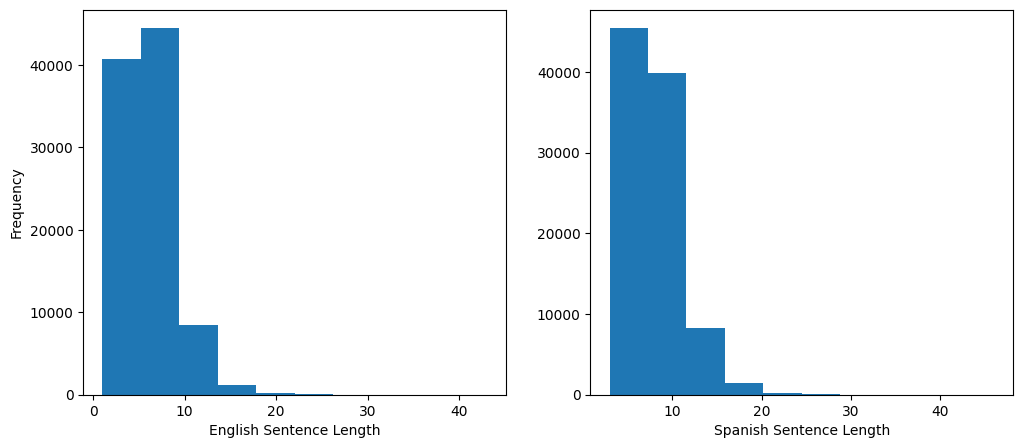

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(eng_length)
plt.xlabel("English Sentence Length")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
plt.hist(spa_length)
plt.xlabel("Spanish Sentence Length")
plt.show();

In [ ]:
punctuation = string.punctuation + "¿"
def preprocessing(text):
  lower = tf.strings.lower(text)
  return tf.strings.regex_replace(
      lower, f"[{re.escape(punctuation)}]", ""
  )


vocab_size = 20000
sequence_length = 20
eng_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

spa_vectorization = layers.TextVectorization(
    standardize=preprocessing,
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
)

train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_english_texts)
spa_vectorization.adapt(train_spanish_texts)

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
@tf.keras.utils.register_keras_serializable(package="MyLayers", name = "PositionalEmbedding")
class PositionalEmbedding(layers.Layer):
  def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
    super().__init__(**kwargs)
    self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero = True)
    self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
    self.sequence_length = sequence_length
    self.input_dim = input_dim
    self.output_dim = output_dim

  def call(self, inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = self.position_embeddings(positions)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return self.token_embeddings.compute_mask(inputs)

  def get_config(self):
    config = super().get_config()
    config.update({
      "output_dim": self.output_dim,
      "sequence_length": self.sequence_length,
      "input_dim": self.input_dim
      })
    return config


@tf.keras.utils.register_keras_serializable(package="MyLayers", name = "TransformerEncoder")
class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.dense_proj = tf.keras.Sequential(
        [layers.Dense(dense_dim, activation="relu"),
         layers.Dense(embed_dim)]
    )
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.supports_masking = True

  def call(self, inputs, mask = None):
    if mask is not None:
      mask = mask[:, tf.newaxis, :]
    attention_output = self.attention(
        query = inputs,
        value = inputs,
        key = inputs,
        attention_mask=mask
    )
    dense_input = self.layernorm_1(inputs + attention_output)
    dense_output = self.layernorm_2(dense_input + self.dense_proj(dense_input))
    return dense_output

  def get_config(self):
    config = super().get_config()
    config.update({
        "embed_dim": self.embed_dim,
        "dense_dim": self.dense_dim,
        "num_heads": self.num_heads
    })
    return config

@tf.keras.utils.register_keras_serializable(package="MyLayers", name = "TransformerDecoder")
class TransformerDecoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim
    )
    self.dense_proj = tf.keras.Sequential(
        [layers.Dense(dense_dim, activation="relu"),
         layers.Dense(embed_dim)]
    )
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.layernorm_3 = layers.LayerNormalization()
    self.supports_masking = True

  def call(self, inputs, encoder_outputs, mask = None):
    if mask is not None:
      mask = mask[:, tf.newaxis, :]
    attention_output = self.attention(
        query = inputs,
        value = inputs,
        key = inputs,
        use_causal_mask = True,
        attention_mask = mask)
    attention_output_1 = self.layernorm_1(inputs + attention_output)
    attention_output_2 = self.attention(
        query = attention_output_1,
        value = encoder_outputs,
        key = encoder_outputs)
    attention_output_2 = self.layernorm_2(attention_output_2 + attention_output_1)
    dense_output = self.layernorm_3(attention_output_2 + self.dense_proj(attention_output_2))
    return dense_output

  def get_config(self):
    config = super().get_config()
    config.update({
        "embed_dim": self.embed_dim,
        "dense_dim": self.dense_dim,
        "num_heads": self.num_heads
    })
    return config

In [ ]:
sequence_length = 20
vocab_size = 20000
embed_dim = 256
dense_dim = 2048
num_heads = 8
encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

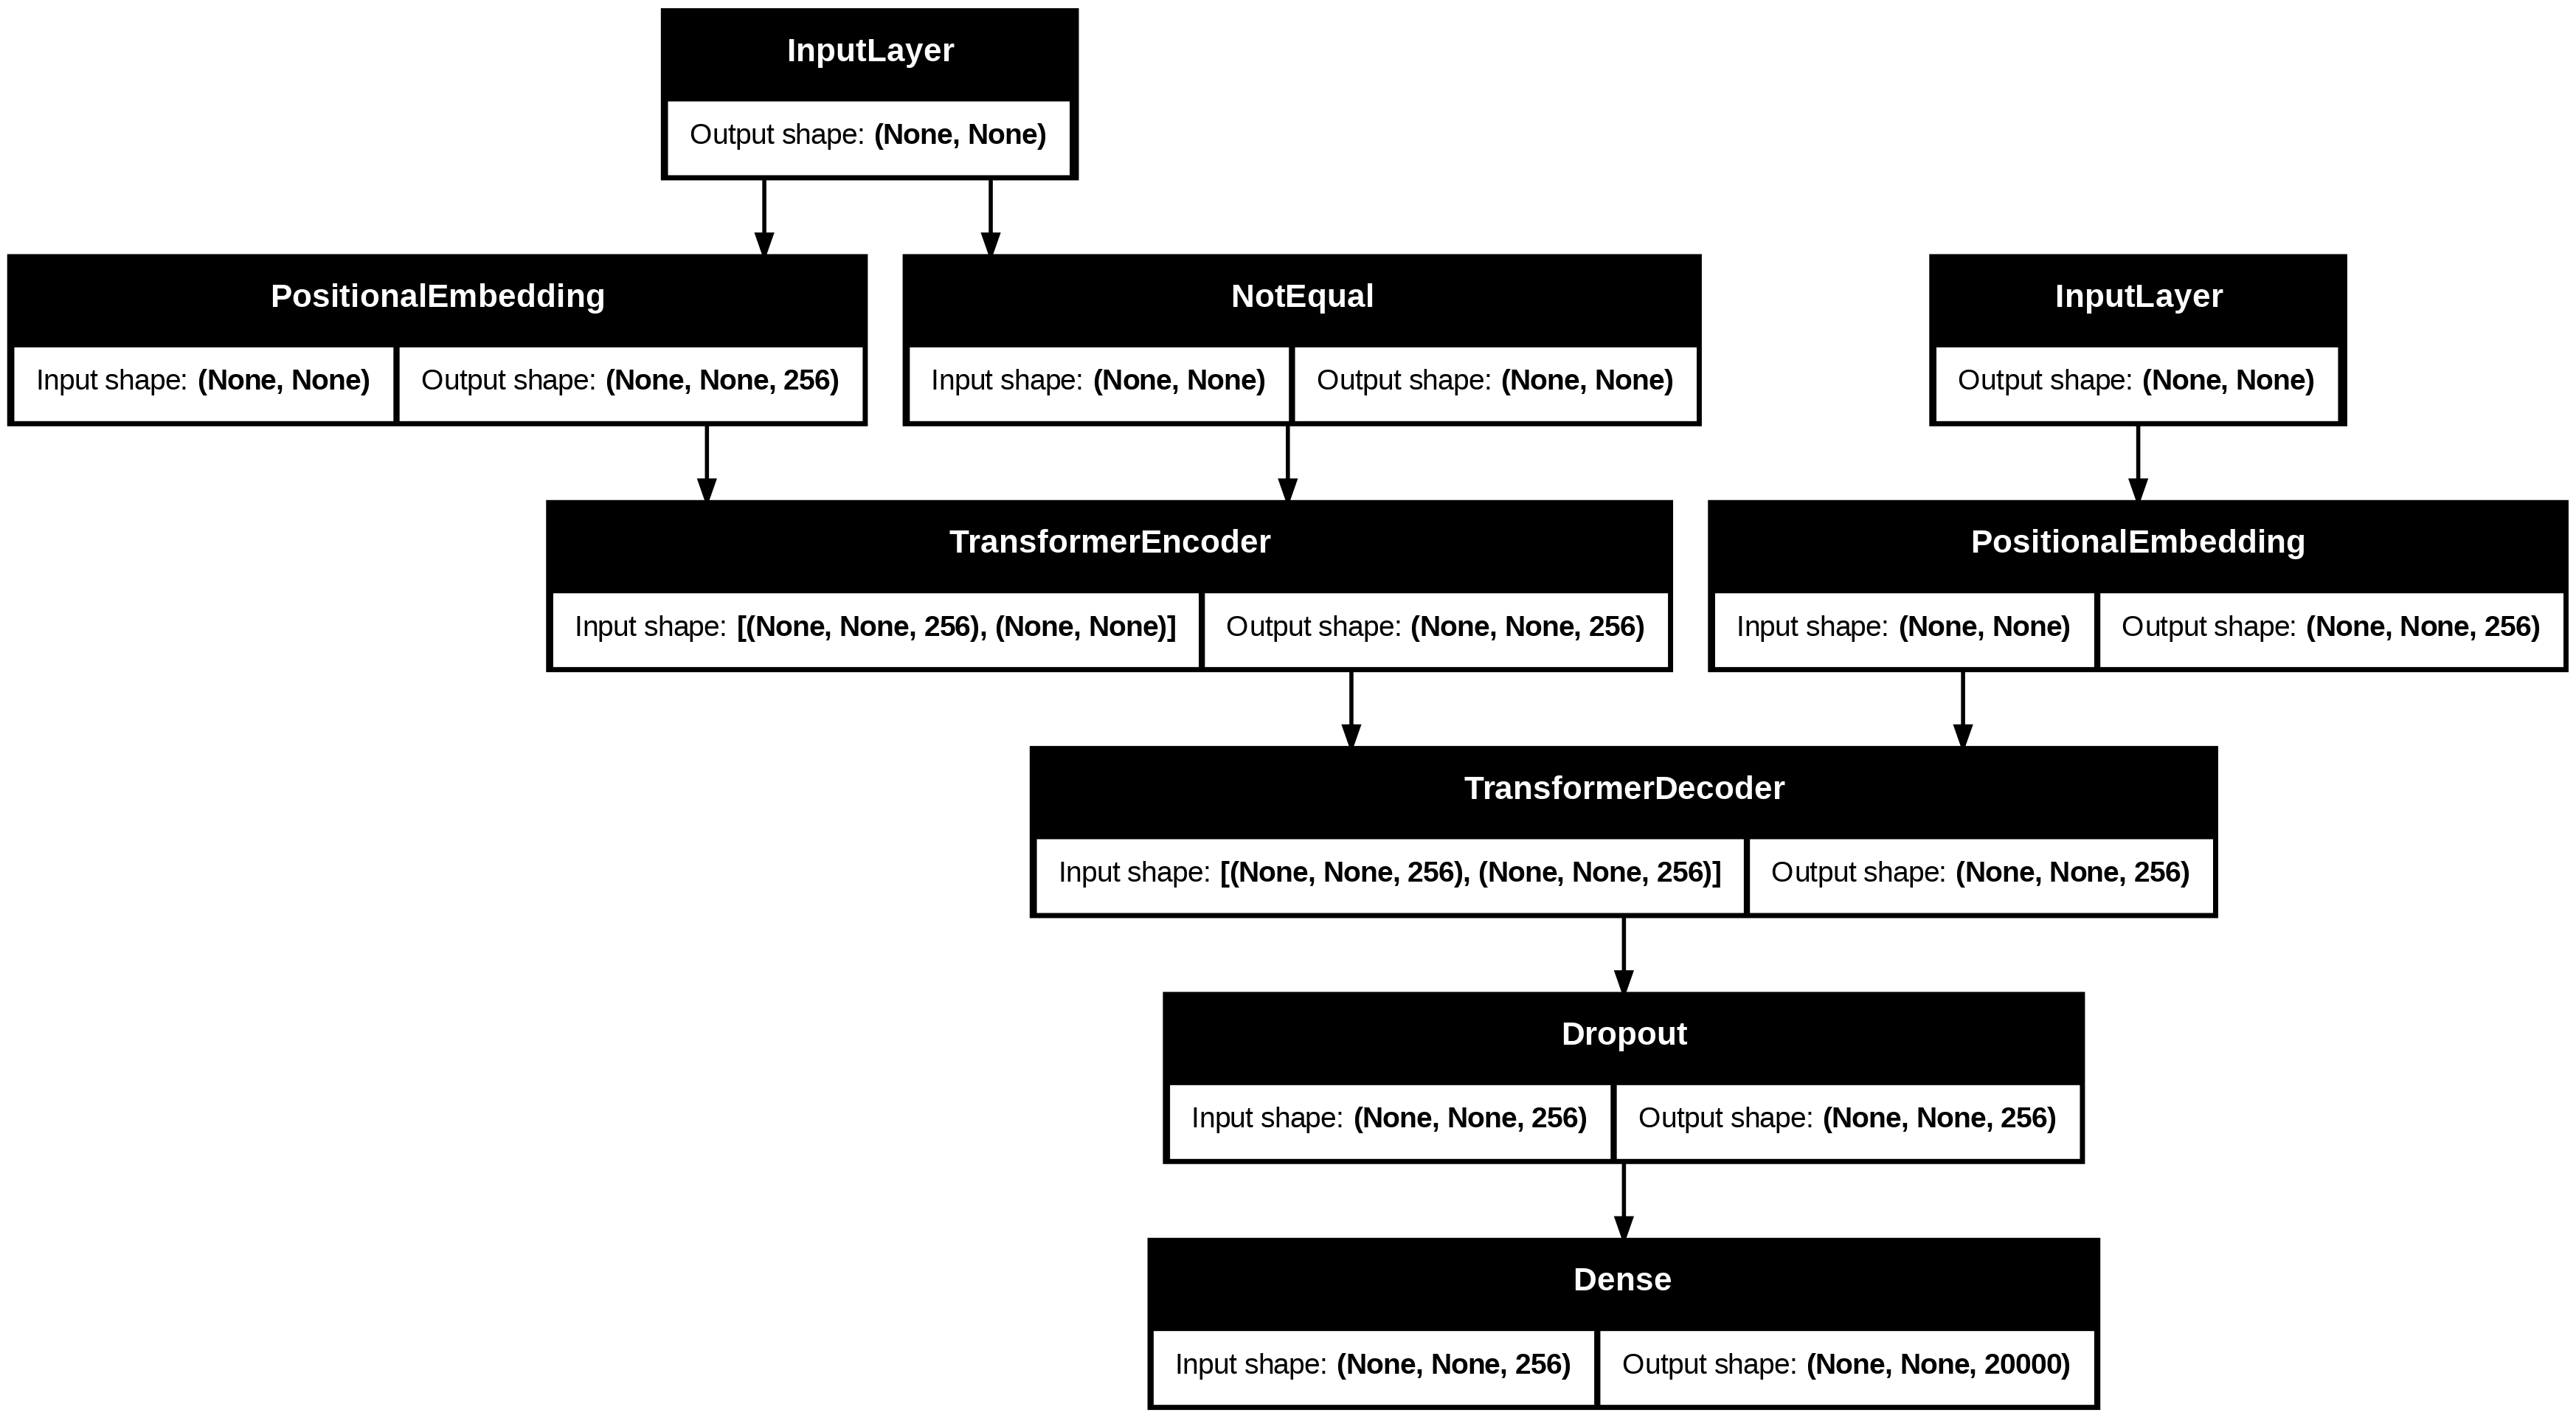

In [ ]:
tf.keras.utils.plot_model(transformer, show_shapes=True)

In [ ]:
transformer.compile(
  optimizer="adam",
  loss="sparse_categorical_crossentropy",
  metrics=["accuracy"],
 )

In [ ]:
mc = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Transformer/transformer.keras",
    save_best_only=True)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr*0.9

lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = transformer.fit(train_ds,
                epochs=30,
                validation_data=val_ds,
                callbacks = [mc, lr])


Epoch 1/30
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 91s 61ms/step - accuracy: 0.3010 - loss: 1.2823 - val_accuracy: 0.2885 - val_loss: 1.5466 - learning_rate: 0.0010
Epoch 2/30
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 142s 61ms/step - accuracy: 0.3064 - loss: 1.1599 - val_accuracy: 0.2909 - val_loss: 1.5187 - learning_rate: 0.0010
Epoch 3/30
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 96s 65ms/step - accuracy: 0.3134 - loss: 1.0374 - val_accuracy: 0.2928 - val_loss: 1.5102 - learning_rate: 0.0010
Epoch 4/30
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 138s 62ms/step - accuracy: 0.3192 - loss: 0.9424 - val_accuracy: 0.2929 - val_loss: 1.5398 - learning_rate: 0.0010
Epoch 5/30
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 92s 62ms/step - accuracy: 0.3235 - loss: 0.8733 - val_accuracy: 0.2935 - val_loss: 1.5507 - learning_rate: 0.0010
Epoch 6/30
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 92s 62ms/step - accuracy: 0.3281 - loss: 0.8095 - val_accuracy: 0.2945 - val_loss: 1.5653 - learning_rate: 0.0010
Epoch 7/30
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 142s 62ms/step - acc

In [ ]:
model  = tf.keras.models.load_model("/content/drive/MyDrive/Transformer/transformer.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_11', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'positional_embedding_12', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_encod

In [ ]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
  tokenized_input_sentence = eng_vectorization([input_sentence])
  decoded_sentence = "sos"
  for i in range(max_decoded_sentence_length):
    tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
    predictions = model([tokenized_input_sentence, tokenized_target_sentence])
    sampled_token_index = np.argmax(predictions[0, i, :])
    sampled_token = spa_index_lookup[sampled_token_index]
    decoded_sentence += " " + sampled_token
    if sampled_token == "eos":
      break
  return decoded_sentence

In [ ]:
random.choice(test_pairs)

('The visitor sat across from me.',
 'sos El visitante se sentó frente a mí. eos')

In [ ]:
for _ in range(10):
 input, output = random.choice(test_pairs)
 print("-"*30)
 print(f"Input: {input}")
 print(f"Predict: {decode_sequence(input)}")
 print(f"True: {output}")

------------------------------
Input: I don't know about you, but I'm starved.
Predict: sos no sé acerca de ti pero estoy muerto de hambre eos
True: sos No sé nada de vos, pero me muero de hambre. eos
------------------------------
Input: I don't have anything to do.
Predict: sos no tengo nada que hacer eos
True: sos No tengo cosas que hacer. eos
------------------------------
Input: Tom is shearing the sheep.
Predict: sos tom es obsceno eos
True: sos Tom está esquilando a la oveja. eos
------------------------------
Input: Winter has gone. Spring has come.
Predict: sos el invierno ha ido la primavera eos
True: sos El invierno se marcha y llega la primavera. eos
------------------------------
Input: We know this.
Predict: sos sabemos esto eos
True: sos Lo sabemos. eos
------------------------------
Input: You should write down whatever seems to be important.
Predict: sos deberías escribir cualquier cosa que es importante eos
True: sos Deberías anotar lo que sea que suene importante. eo